In [1]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from WCTE_event_display.EventDisplay      import EventDisplay

from WCSimFilePackages.npz_to_df import simple_truehits_info_to_df
from WCSimFilePackages.npz_to_df import super_simple_track_info_to_df

from tqdm import tqdm

pltext.style()

# Data

In [63]:
events_for_reconstruction = pd.read_csv("/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/data/run_1770_forBONSAI_separated_chargeFiltered500-12500.csv")
# events_for_reconstruction = pd.read_csv("/home/usc/ie/dcr/hk/nicf_analysis/data_analysis/NB/test.csv")

valid_events = pd.read_pickle("/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/bonsai/run_1770_validEvents.pkl").values
valid_events = events_for_reconstruction.iloc[valid_events]["event_id"].values
real_events = events_for_reconstruction[events_for_reconstruction["event_id"].isin(valid_events)]

print(len(events_for_reconstruction), len(valid_events), len(real_events))

10960110 295581 295603


In [43]:
events_for_reconstruction = pd.read_csv("/home/usc/ie/dcr/hk/nicf_analysis/data_analysis/NB/test.csv")

valid_events = pd.read_pickle("/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/bonsai/run_1769_validEvents.pkl").values
valid_events = events_for_reconstruction.iloc[valid_events]["event_id"].values
real_events = events_for_reconstruction[events_for_reconstruction["event_id"].isin(valid_events)]

print(len(events_for_reconstruction), len(valid_events), len(real_events))

2594898 313193 313229


In [44]:
events_for_reconstruction.head()

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,21284.615675,155.0,106.0,66.0,17.0,15.0
1,0.0,21285.519916,418.0,106.0,66.0,16.0,14.0
2,0.0,21285.547761,159.0,101.0,20.0,12.0,4.0
3,0.0,21286.038121,149.0,106.0,66.0,14.0,13.0
4,0.0,21286.234292,125.0,106.0,66.0,11.0,11.0


### Map Slot and Position IDs Into WCSim PMT IDs

In [64]:
def get_geo_mapping():
    geo = pd.read_csv("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/geofile_NuPRISMBeamTest_16cShort_mPMT.txt", 
                      index_col=False,      # Do not use any column as the index
                      sep='\s+',            # Use whitespace as separator
                      skiprows=5,           # Skip the first 5 header lines
                      names=["id","mpmtid","spmtid",
                             "x","y","z","dx","dy","dz", "cyloc"])  # Explicit column names

    return geo

geo = get_geo_mapping()

def getxyz(geo, mpmtids, posids):
    # Build a single lookup dictionary: {(mpmtid, spmtid): (x, y, z, id)}
    lookup = {
        (row.mpmtid, row.spmtid): (row.x, row.y, row.z, row.id)
        for row in geo.itertuples(index=False)
    }

    # Adjust input IDs to match geometry convention
    keys = zip((mid + 1 for mid in mpmtids), (sid + 1 for sid in posids))

    # Use the lookup dictionary to retrieve values efficiently
    results = [lookup.get(k, (-999.9, -999.9, -999.9, -999)) for k in keys]

    # Unpack results into separate arrays
    if len(results) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    x, y, z, c = map(np.array, zip(*results))

    return x, y, z, c

In [65]:
x, y, z, pmt_id = getxyz(geo, real_events["hit_mpmt_slot_ids"], real_events["hit_pmt_position_ids"])

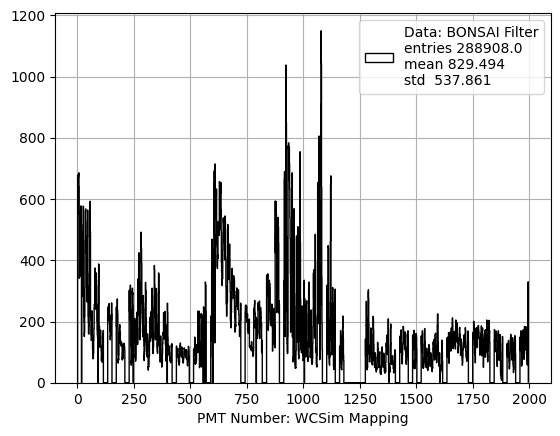

In [66]:
pltext.hist(pmt_id, 1995, range=(0, 1995), xylabels="PMT Number: WCSim Mapping", label="Data: BONSAI Filter");

# Simulation

In [8]:
npz_up     = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim_old/install/npz/1Mneutrons_NiCf_piFix_QGSP_BIC_HP_pos00-80.npz'
npz_center = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim_old/install/npz/1Mneutrons_NiCf_piFix_QGSP_BIC_HP_pos000.npz'
npz_down   = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim_old/install/npz/1Mneutrons_NiCf_piFix_QGSP_BIC_HP_pos00100.npz'
nevents = 30901

# Creación del DataFrame de DigiHits usando la función digihits_info_to_df
df_trueHits_up     = simple_truehits_info_to_df(npz_up).dropna()
df_trueHits_center = simple_truehits_info_to_df(npz_center).dropna()
df_trueHits_down   = simple_truehits_info_to_df(npz_down).dropna()

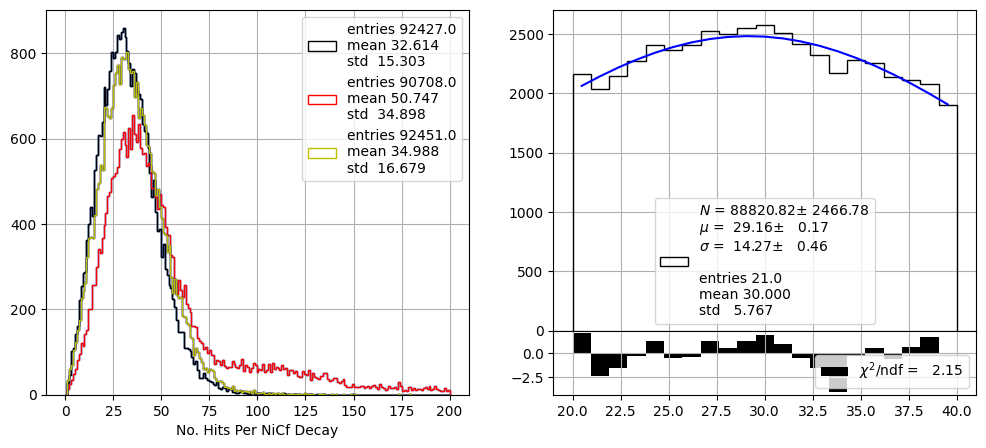

In [9]:
# Quantum Efficiency: Number Of Hits Expected In The Whole PMTs Set Per NiCf Event
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(df_trueHits_up.groupby("event_id").count().values, 201, xylabels="No. Hits Per NiCf Decay", range=(0, 200));
pltext.hist(df_trueHits_center.groupby("event_id").count().values, 201, xylabels="No. Hits Per NiCf Decay", range=(0, 200));
pltext.hist(df_trueHits_down.groupby("event_id").count().values, 201, xylabels="No. Hits Per NiCf Decay", range=(0, 200));

subplot(2)
pltext.hfit(df_trueHits_up.groupby("event_id").count().values, 21, "gaus", stats = True, residuals = True, range=(20, 40));

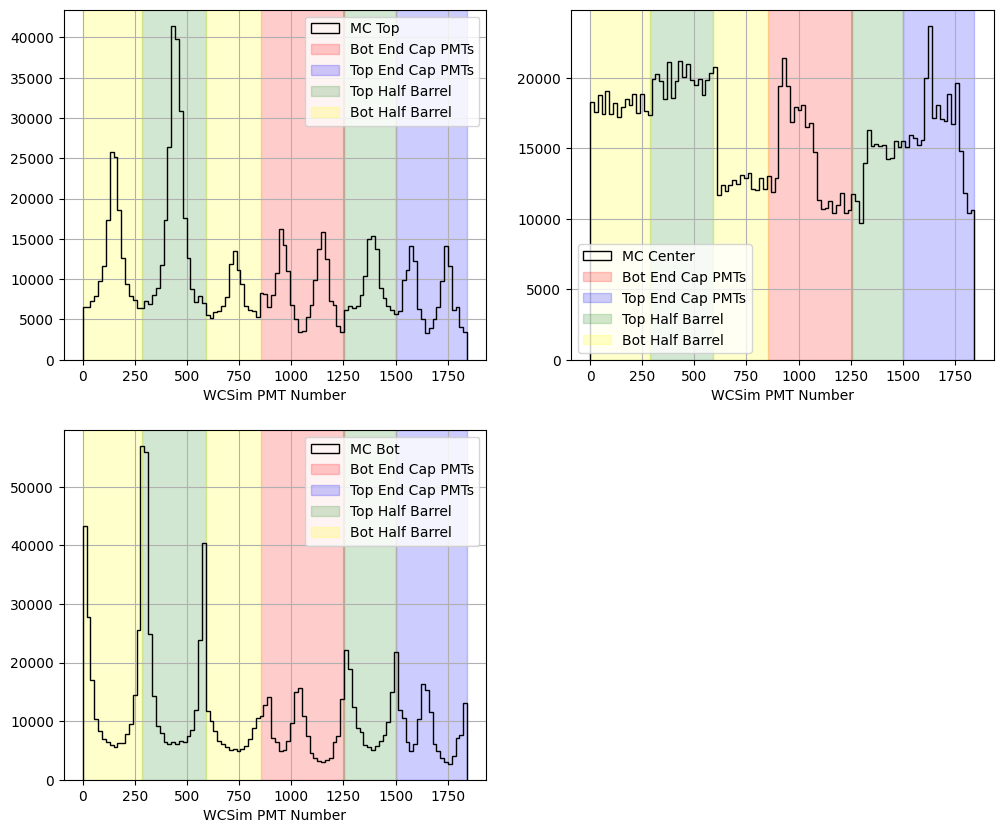

In [10]:
subplot = pltext.canvas(3)

subplot(1)
pltext.hist(df_trueHits_up["true_hit_pmt"].values,     100, range=(0, 1843), stats=False, density=False, xylabels="WCSim PMT Number", label="MC Top");

plt.axvspan(855, 1254,  color="red", alpha=0.2, label="Bot End Cap PMTs")
plt.axvspan(1501, 1843, color="blue", alpha=0.2, label="Top End Cap PMTs")
plt.axvspan(285, 589,  color="forestgreen", alpha=0.2, label="Top Half Barrel")
plt.axvspan(1254, 1501,  color="forestgreen", alpha=0.2)
plt.axvspan(0, 285,  color="yellow", alpha=0.2, label="Bot Half Barrel")
plt.axvspan(589, 855,  color="yellow", alpha=0.2)
plt.legend();

subplot(2)
pltext.hist(df_trueHits_center["true_hit_pmt"].values, 100, range=(0, 1843), stats=False, density=False, xylabels="WCSim PMT Number", label="MC Center");

plt.axvspan(855, 1254,  color="red", alpha=0.2, label="Bot End Cap PMTs")
plt.axvspan(1501, 1843, color="blue", alpha=0.2, label="Top End Cap PMTs")
plt.axvspan(285, 589,  color="forestgreen", alpha=0.2, label="Top Half Barrel")
plt.axvspan(1254, 1501,  color="forestgreen", alpha=0.2)
plt.axvspan(0, 285,  color="yellow", alpha=0.2, label="Bot Half Barrel")
plt.axvspan(589, 855,  color="yellow", alpha=0.2)
plt.legend();

subplot(3)
pltext.hist(df_trueHits_down["true_hit_pmt"].values,   100, range=(0, 1843), stats=False, density=False, xylabels="WCSim PMT Number", label="MC Bot");

plt.axvspan(855, 1254,  color="red", alpha=0.2, label="Bot End Cap PMTs")
plt.axvspan(1501, 1843, color="blue", alpha=0.2, label="Top End Cap PMTs")
plt.axvspan(285, 589,  color="forestgreen", alpha=0.2, label="Top Half Barrel")
plt.axvspan(1254, 1501,  color="forestgreen", alpha=0.2)
plt.axvspan(0, 285,  color="yellow", alpha=0.2, label="Bot Half Barrel")
plt.axvspan(589, 855,  color="yellow", alpha=0.2)
plt.legend();

# Comparison

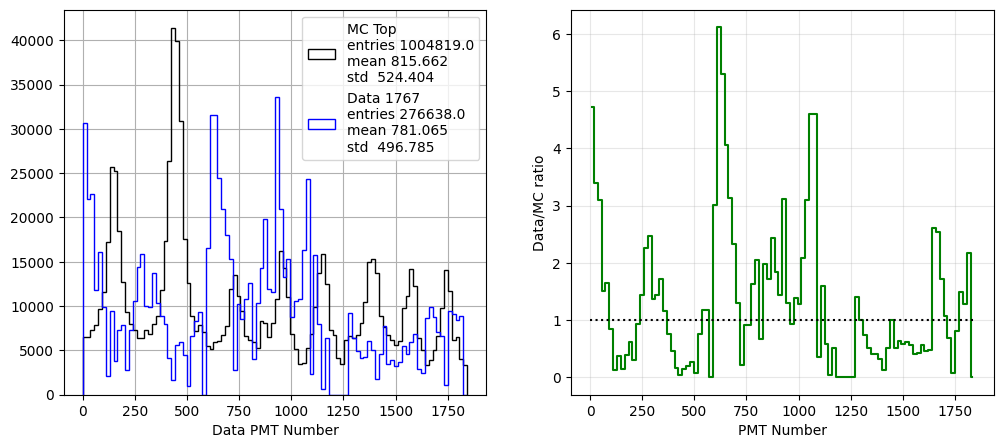

In [67]:
v_wcsim, b_wcsim = np.histogram(df_trueHits_up["true_hit_pmt"].values, 100, range=(0, 1843));
v_datas, b_datas = np.histogram(pmt_id,                                100, range=(0, 1843));

N_nicf = v_wcsim.sum()
N_bkg  = v_datas.sum()
bins = np.arange(0, 100)

# --- Factor de escala global (regla de tres) ---
scale_factor = len(df_trueHits_up["true_hit_pmt"].values)/len(pmt_id)

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])

subplot = pltext.canvas(2)

subplot(1)
v_wcsim, b_wcsim, _ = pltext.hist(df_trueHits_up["true_hit_pmt"].values, 100, range=(0, 1843), xylabels="WCSim PMT Number", label="MC Top");
v_datas, b_datas, _ = pltext.hist(pmt_id,                                100, range=(0, 1843), xylabels="Data PMT Number", weights=np.ones_like(pmt_id) * scale_factor, label="Data 1767");

subplot(2)
bin_centers = 0.5 * (b_wcsim[1:] + b_wcsim[:-1])
ratio = np.divide(v_datas, v_wcsim)
plt.step(bin_centers, ratio, where='mid', color='green')
plt.ylabel("Data/MC ratio")
plt.xlabel("PMT Number")
plt.grid(alpha=0.3)
plt.hlines(1.0, 0, 1843, linestyles=":", color="k");

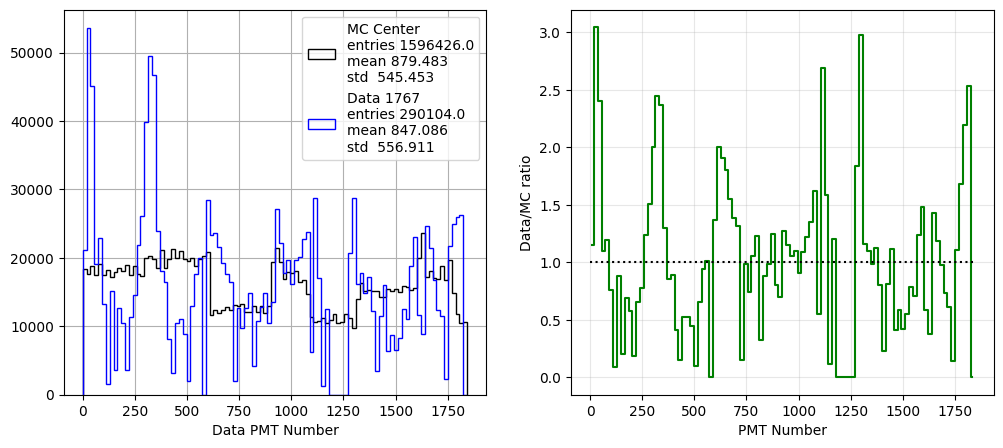

In [53]:
v_wcsim, b_wcsim = np.histogram(df_trueHits_center["true_hit_pmt"].values, 100, range=(0, 1843));
v_datas, b_datas = np.histogram(pmt_id,                                100, range=(0, 1843));

N_nicf = v_wcsim.sum()
N_bkg  = v_datas.sum()
bins = np.arange(0, 100)

# --- Factor de escala global (regla de tres) ---
scale_factor = len(df_trueHits_center["true_hit_pmt"].values)/len(pmt_id)

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])

subplot = pltext.canvas(2)

subplot(1)
v_wcsim, b_wcsim, _ = pltext.hist(df_trueHits_center["true_hit_pmt"].values, 100, range=(0, 1843), xylabels="WCSim PMT Number", label="MC Center");
v_datas, b_datas, _ = pltext.hist(pmt_id,                                100, range=(0, 1843), xylabels="Data PMT Number", weights=np.ones_like(pmt_id) * scale_factor, label="Data 1767");

subplot(2)
bin_centers = 0.5 * (b_wcsim[1:] + b_wcsim[:-1])
ratio = np.divide(v_datas, v_wcsim)
plt.step(bin_centers, ratio, where='mid', color='green')
plt.ylabel("Data/MC ratio")
plt.xlabel("PMT Number")
plt.grid(alpha=0.3)
plt.hlines(1.0, 0, 1843, linestyles=":", color="k");

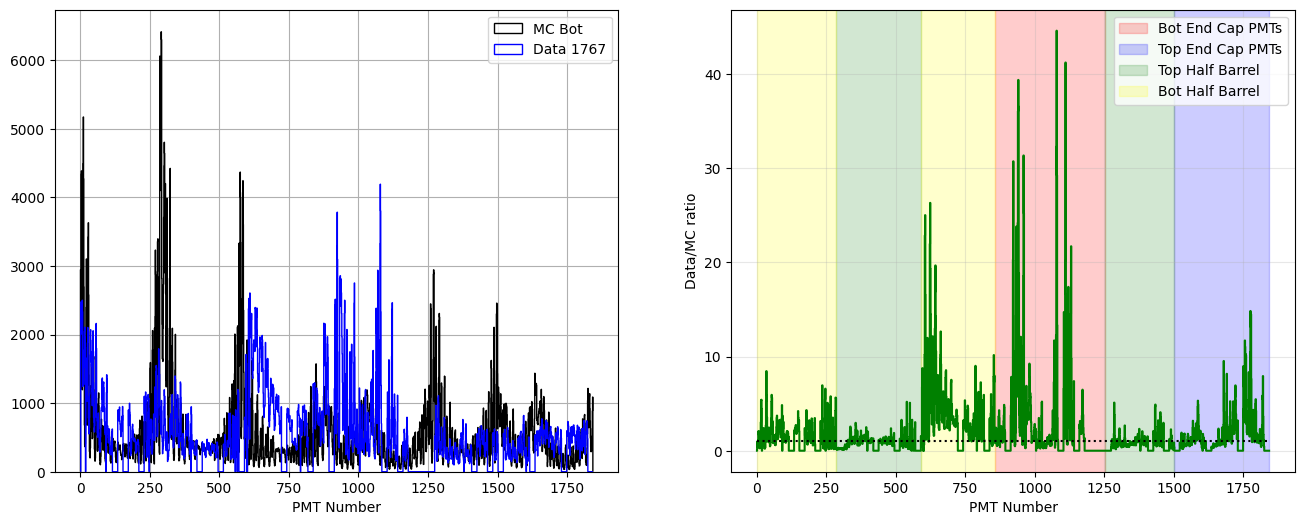

In [68]:
v_wcsim, b_wcsim = np.histogram(df_trueHits_down["true_hit_pmt"].values, 1843, range=(0, 1843));
v_datas, b_datas = np.histogram(pmt_id,                                1843, range=(0, 1843));

N_nicf = v_wcsim.sum()
N_bkg  = v_datas.sum()
bins = np.arange(0, 1843)

# --- Factor de escala global (regla de tres) ---
scale_factor = len(df_trueHits_down["true_hit_pmt"].values)/len(pmt_id)

# --- Dibujar comparación (barras) ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])

subplot = pltext.canvas(2,2,6,8)

subplot(1)
v_wcsim, b_wcsim, _ = pltext.hist(df_trueHits_down["true_hit_pmt"].values, 1843, range=(0, 1843), stats=False, xylabels="PMT Number", label="MC Bot");
v_datas, b_datas, _ = pltext.hist(pmt_id,                                  1843, range=(0, 1843), stats=False, xylabels="PMT Number", weights=np.ones_like(pmt_id) * scale_factor, label="Data 1767");

subplot(2)
bin_centers = 0.5 * (b_wcsim[1:] + b_wcsim[:-1])
ratio = np.divide(v_datas, v_wcsim)

plt.step(bin_centers, ratio, where='mid', color='green')
plt.ylabel("Data/MC ratio")
plt.xlabel("PMT Number")
plt.grid(alpha=0.3)
plt.hlines(1.0, 0, 1843, linestyles=":", color="k");

plt.axvspan(855, 1254,  color="red", alpha=0.2, label="Bot End Cap PMTs")
plt.axvspan(1501, 1843, color="blue", alpha=0.2, label="Top End Cap PMTs")
plt.axvspan(285, 589,  color="forestgreen", alpha=0.2, label="Top Half Barrel")
plt.axvspan(1254, 1501,  color="forestgreen", alpha=0.2)
plt.axvspan(0, 285,  color="yellow", alpha=0.2, label="Bot Half Barrel")
plt.axvspan(589, 855,  color="yellow", alpha=0.2)
plt.legend();

# Event Display

In [146]:
real_events

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,21284.615675,155.0,106.0,66.0,17.0,15.0
1,0.0,21285.519916,418.0,106.0,66.0,16.0,14.0
2,0.0,21285.547761,159.0,101.0,20.0,12.0,4.0
3,0.0,21286.038121,149.0,106.0,66.0,14.0,13.0
4,0.0,21286.234292,125.0,106.0,66.0,11.0,11.0
...,...,...,...,...,...,...,...
58249,3279.0,412220.975052,67.0,102.0,22.0,14.0,13.0
58250,3279.0,412221.343038,348.0,46.0,4.0,10.0,10.0
58251,3279.0,412221.528681,49.0,1.0,70.0,15.0,5.0
58252,3279.0,412221.887200,102.0,112.0,35.0,6.0,8.0


In [166]:
run_slots     = real_events["hit_mpmt_slot_ids"]
run_positions = real_events["hit_pmt_position_ids"]
run_charges   = real_events["hit_pmt_charges"]

(2014,)


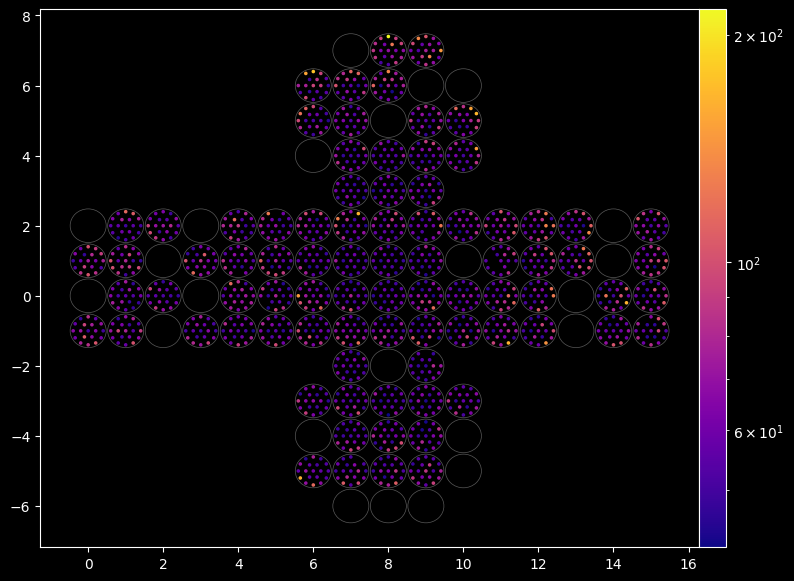

In [176]:
pmt_id = (run_slots*19 + run_positions).astype(int)
data_to_plot = run_charges

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

pltext.style()